In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss

In [27]:
# Load data
games = pd.read_csv("data/MRegularSeasonCompactResults.csv")  
seeds = pd.read_csv("data/MNCAATourneySeeds.csv")
rankings = pd.read_csv("data/MMasseyOrdinals.csv")
teams = pd.read_csv("data/MTeams.csv")
game_details = pd.read_csv("data/MRegularSeasonDetailedResults.csv") 
seasons = pd.read_csv("data/MSeasons.csv")

In [70]:
# Define seasons for training and prediction
TRAIN_SEASON = 2024
PREDICT_SEASON = 2025

# Get the current ranking day from 2025 season - this will be our reference point
CURRENT_RANKING_DAY = rankings[rankings['Season'] == PREDICT_SEASON]['RankingDayNum'].max()
print(f"Using RankingDayNum {CURRENT_RANKING_DAY} from 2025 season as reference point")

# For training data, filter 2024 season and use same day number as 2025
train_games = games[
    (games["Season"] == TRAIN_SEASON) & 
    (games["DayNum"] <= CURRENT_RANKING_DAY)
]
train_rankings = rankings[
    (rankings["Season"] == TRAIN_SEASON) & 
    (rankings["RankingDayNum"] <= CURRENT_RANKING_DAY)
]
train_rankings = train_rankings.loc[train_rankings.groupby(["TeamID", "SystemName"])["RankingDayNum"].idxmax()]
train_seeds = seeds[seeds["Season"] == TRAIN_SEASON]

# For prediction data, we'll use 2025 season rankings only
# Note: Seeds for 2025 will not be available until Selection Sunday
predict_rankings = rankings[
    (rankings["Season"] == PREDICT_SEASON) & 
    (rankings["RankingDayNum"] <= CURRENT_RANKING_DAY)
]
predict_rankings = predict_rankings.loc[predict_rankings.groupby(["TeamID", "SystemName"])["RankingDayNum"].idxmax()]

# Verify the filtering worked
print("\nData Summary:")
print(f"Number of 2024 games up to day {CURRENT_RANKING_DAY}:", len(train_games))
print("Number of 2024 seeds:", len(train_seeds))
print("Number of 2024 teams with rankings:", len(train_rankings["TeamID"].unique()))
print("Number of 2025 teams with rankings:", len(predict_rankings["TeamID"].unique()))
print("\nRanking systems available in 2024:", train_rankings["SystemName"].unique())
print("Ranking systems available in 2025:", predict_rankings["SystemName"].unique())

Using RankingDayNum 121 from 2025 season as reference point

Data Summary:
Number of 2024 games up to day 121: 5202
Number of 2024 seeds: 68
Number of 2024 teams with rankings: 362
Number of 2025 teams with rankings: 364

Ranking systems available in 2024: ['7OT' 'ARG' 'BAR' 'BBT' 'BIH' 'BMN' 'BNZ' 'BWE' 'COL' 'DCI' 'DII' 'DOK'
 'DOL' 'DP' 'DUN' 'EBP' 'EMK' 'ESR' 'FAS' 'HAS' 'INC' 'JJK' 'JNG' 'KPK'
 'LMC' 'LOG' 'MAS' 'MB' 'MGS' 'MMG' 'MOR' 'NET' 'NOL' 'OMY' 'PAC' 'PGH'
 'PIR' 'POM' 'REW' 'RMS' 'RPI' 'RT' 'RTH' 'RTP' 'SEL' 'SFX' 'SMS' 'SPR'
 'SRS' 'STH' 'STY' 'TPR' 'TRK' 'TRP' 'WIL' 'WLK' 'WOL' 'AP' 'DES' 'USA']
Ranking systems available in 2025: ['7OT' 'ARG' 'BAR' 'BBT' 'BIH' 'BMN' 'BNZ' 'BWE' 'COL' 'DCI' 'DII' 'DOK'
 'DOL' 'DP' 'DUN' 'EBP' 'EMK' 'ESR' 'FAS' 'HAS' 'INC' 'JJK' 'JNG' 'KPI'
 'KPK' 'LAB' 'LOG' 'MAS' 'MB' 'MGS' 'MMG' 'MOR' 'NET' 'NOL' 'OMY' 'PAC'
 'PGH' 'PIR' 'POM' 'REW' 'RMS' 'RPI' 'RT' 'RTH' 'SMS' 'SPR' 'SRS' 'STY'
 'TRK' 'TRP' 'WAB' 'WIL' 'WLK' 'WOL' 'AP' 'DES' 'USA']


In [71]:
# Create region mapping dictionary for 2024
region_map_2024 = {
    'W': seasons[seasons['Season'] == 2024]['RegionW'].iloc[0],
    'X': seasons[seasons['Season'] == 2024]['RegionX'].iloc[0],
    'Y': seasons[seasons['Season'] == 2024]['RegionY'].iloc[0],
    'Z': seasons[seasons['Season'] == 2024]['RegionZ'].iloc[0]
}

# Create an explicit copy of train_seeds before modifying
train_seeds = train_seeds.copy()

# Extract numeric seed values and region information using .loc
train_seeds.loc[:, 'SeedValue'] = train_seeds['Seed'].str.extract('(\d+)').astype(float)
train_seeds.loc[:, 'Region'] = train_seeds['Seed'].str[0]  # Extract W, X, Y, or Z
train_seeds.loc[:, 'RegionName'] = train_seeds['Region'].map(region_map_2024)  # Map to actual region names

In [72]:
# Verify the filtering worked
print("Number of games for 2024:", len(train_games))
print("Number of seeds for 2024:", len(train_seeds))

Number of games for 2024: 5202
Number of seeds for 2024: 68


In [73]:
# Extract numeric seed value
seeds["SeedValue"] = seeds["Seed"].str.extract("(\d+)").astype(float)

In [74]:
print(seeds.head(25))

    Season Seed  TeamID  SeedValue
0     1985  W01    1207        1.0
1     1985  W02    1210        2.0
2     1985  W03    1228        3.0
3     1985  W04    1260        4.0
4     1985  W05    1374        5.0
5     1985  W06    1208        6.0
6     1985  W07    1393        7.0
7     1985  W08    1396        8.0
8     1985  W09    1439        9.0
9     1985  W10    1177       10.0
10    1985  W11    1455       11.0
11    1985  W12    1330       12.0
12    1985  W13    1233       13.0
13    1985  W14    1318       14.0
14    1985  W15    1273       15.0
15    1985  W16    1250       16.0
16    1985  X01    1385        1.0
17    1985  X02    1433        2.0
18    1985  X03    1301        3.0
19    1985  X04    1424        4.0
20    1985  X05    1449        5.0
21    1985  X06    1409        6.0
22    1985  X07    1104        7.0
23    1985  X08    1234        8.0
24    1985  X09    1116        9.0


In [75]:
# Define the preferred ranking systems
preferred_systems = ["SAG", "TPR", "MAS", "RDT", "ESR", "POM", "USA", "AP"]

# Process training rankings (2024)
train_rankings_pivot = train_rankings.pivot_table(
    index="TeamID", 
    columns="SystemName", 
    values="OrdinalRank",
    aggfunc='mean'  # This handles duplicate entries by taking their mean
)

# Process prediction rankings (2025)
predict_rankings_pivot = predict_rankings.pivot_table(
    index="TeamID", 
    columns="SystemName", 
    values="OrdinalRank",
    aggfunc='mean'  # This handles duplicate entries by taking their mean
)

# Filter for only the available preferred systems in each dataset
available_systems_train = [sys for sys in preferred_systems if sys in train_rankings_pivot.columns]
available_systems_predict = [sys for sys in preferred_systems if sys in predict_rankings_pivot.columns]

train_rankings_pivot = train_rankings_pivot[available_systems_train]
predict_rankings_pivot = predict_rankings_pivot[available_systems_predict]

# Normalize rankings to 0-1 scale where 1 is best
for column in train_rankings_pivot.columns:
    max_rank = train_rankings_pivot[column].max()
    train_rankings_pivot[column] = 1 - (train_rankings_pivot[column] - 1) / (max_rank - 1)

for column in predict_rankings_pivot.columns:
    max_rank = predict_rankings_pivot[column].max()
    predict_rankings_pivot[column] = 1 - (predict_rankings_pivot[column] - 1) / (max_rank - 1)

# Print the first 25 rows of each rankings pivot table
print("2024 Training Rankings:")
print(train_rankings_pivot.head(25))
print("\n2025 Prediction Rankings:")
print(predict_rankings_pivot.head(25))

2024 Training Rankings:
SystemName       TPR       MAS       ESR       POM       USA        AP
TeamID                                                                
1101        0.451524  0.501385  0.396122  0.396122       NaN       NaN
1102        0.385042  0.318560  0.224377  0.282548       NaN       NaN
1103        0.689751  0.714681  0.734072  0.722992       NaN       NaN
1104        0.966759  0.975069  0.969529  0.980609  0.333333  0.375000
1105        0.038781  0.069252  0.038781  0.077562       NaN       NaN
1106        0.177285  0.096953  0.152355  0.144044       NaN       NaN
1107        0.224377  0.207756  0.274238  0.304709       NaN       NaN
1108        0.144044  0.157895  0.263158  0.199446       NaN       NaN
1110        0.221607  0.227147  0.240997  0.235457       NaN       NaN
1111        0.828255  0.767313  0.819945  0.800554       NaN       NaN
1112        0.988920  0.988920  0.972299  0.991690  0.833333  0.833333
1113        0.673130  0.759003  0.709141  0.684211   

In [76]:
# Get list of tournament teams
tournament_teams = train_seeds['TeamID'].unique()

# Extract matchup results for training data (2024), filtering for tournament teams only
# and only using games before CURRENT_RANKING_DAY to match prediction data timeframe
train_games_tourney = train_games[
    (train_games['WTeamID'].isin(tournament_teams)) & 
    (train_games['LTeamID'].isin(tournament_teams)) &
    (train_games['DayNum'] <= CURRENT_RANKING_DAY)  # Updated to use CURRENT_RANKING_DAY
]

# Get the most recent matchup between any two tournament teams
train_last_games = train_games_tourney.sort_values('DayNum', ascending=False).drop_duplicates(subset=['WTeamID', 'LTeamID'])

# Print some debugging information
print("Number of tournament teams:", len(tournament_teams))
print(f"Number of games between tournament teams before day {CURRENT_RANKING_DAY}:", len(train_games_tourney))
print("Number of unique matchups between tournament teams:", len(train_last_games))

# Convert training game results into matchup format
train_matchups_win = train_last_games[['Season', 'WTeamID', 'LTeamID']].copy()
train_matchups_win['Win'] = 1
train_matchups_win.columns = ['Season', 'Team1', 'Team2', 'Win']

train_matchups_loss = train_last_games[['Season', 'LTeamID', 'WTeamID']].copy()
train_matchups_loss['Win'] = 0
train_matchups_loss.columns = ['Season', 'Team1', 'Team2', 'Win']

# Combine both perspectives for training data
train_matchups = pd.concat([train_matchups_win, train_matchups_loss], ignore_index=True)

# Add team features to matchups
train_matchups = train_matchups.merge(
    train_team_features[['TeamID', 'SeedValue', 'RegionName'] + available_systems_train + ['Last10WinRate']], 
    left_on='Team1', 
    right_on='TeamID', 
    how='inner'
).merge(
    train_team_features[['TeamID', 'SeedValue', 'RegionName'] + available_systems_train + ['Last10WinRate']], 
    left_on='Team2', 
    right_on='TeamID', 
    suffixes=('_1', '_2'),
    how='inner'
)

# Print sample of matchup results with numeric seeds and regions
print(f"\n2024 Training Matchups Sample (using games before day {CURRENT_RANKING_DAY}):")
print(train_matchups[['Team1', 'Team2', 'Win', 'SeedValue_1', 'RegionName_1', 'SeedValue_2', 'RegionName_2', 'Last10WinRate_1', 'Last10WinRate_2']].head())
print("\nShape of training matchups:", train_matchups.shape)

# Print teams with missing information (should be none now)
missing_info = train_matchups[train_matchups['SeedValue_2'].isna()][['Team1', 'Team2']].head()
if len(missing_info) > 0:
    print("\nSample of matchups with missing seed information:")
    print(missing_info)

Number of tournament teams: 68
Number of games between tournament teams before day 121: 264
Number of unique matchups between tournament teams: 247

2024 Training Matchups Sample (using games before day 121):
   Team1  Team2  Win  SeedValue_1 RegionName_1  SeedValue_2 RegionName_2  \
0   1401   1280    1          0.0        South          0.0         West   
1   1397   1376    1          0.0      Midwest          0.0      Midwest   
2   1277   1321    1          0.0         West          0.0         East   
3   1235   1140    1          0.0         East          0.0         East   
4   1163   1266    1          0.0         East          0.0        South   

   Last10WinRate_1  Last10WinRate_2  
0              0.5              0.5  
1              0.9              0.7  
2              0.6              0.5  
3              0.8              0.6  
4              0.9              0.7  

Shape of training matchups: (494, 24)


In [77]:
# Function to get last n games' win rate for a specific season
def get_last_n_games_win_rate(team_id, season, n=10):
    season_games = games[games["Season"] == season]
    recent_games = season_games[
        ((season_games["WTeamID"] == team_id) | (season_games["LTeamID"] == team_id)) & 
        (season_games["DayNum"] <= CURRENT_RANKING_DAY)
    ]
    recent_games = recent_games.tail(n)
    wins = (recent_games["WTeamID"] == team_id).sum()
    return wins / n if len(recent_games) > 0 else 0.5  # Default to 50% if no games

# Create team features for training data (2024)
train_team_features = train_seeds.merge(train_rankings_pivot, on="TeamID", how="left").fillna(0)

# Add win rates for training teams using CURRENT_RANKING_DAY to match prediction timeframe
train_team_features["Last10WinRate"] = train_team_features["TeamID"].apply(
    lambda team: get_last_n_games_win_rate(team, TRAIN_SEASON)
)

# Create team features for prediction data (2025) - rankings only since seeds aren't available yet
predict_team_features = predict_rankings_pivot.copy()

# Add win rates for prediction teams using current point in season
predict_team_features["Last10WinRate"] = predict_team_features.index.map(
    lambda team: get_last_n_games_win_rate(team, PREDICT_SEASON)
)

# Get available systems for each dataset
available_systems_predict = [col for col in predict_rankings_pivot.columns if col != 'TeamID']

# Print verification of features
print(f"Using games up to day {CURRENT_RANKING_DAY} for win rate calculations\n")
print("2024 Training Team Features:")
print(train_team_features[["TeamID", "SeedValue", "RegionName", "Last10WinRate"] + available_systems_train].head())
print("\nShape of training features:", train_team_features.shape)

print("\n2025 Prediction Team Features (no seeds yet):")
print(predict_team_features[["Last10WinRate"] + available_systems_predict].head())
print("\nShape of prediction features:", predict_team_features.shape)

# Print available ranking systems for verification
print("\nAvailable ranking systems for training:", available_systems_train)
print("Available ranking systems for prediction:", available_systems_predict)

# Print systems that are in training but not in prediction
missing_systems = set(available_systems_train) - set(available_systems_predict)
if missing_systems:
    print("\nRanking systems in training but not in prediction:", missing_systems)

Using games up to day 121 for win rate calculations

2024 Training Team Features:
   TeamID  SeedValue RegionName  Last10WinRate       TPR       MAS       ESR  \
0    1163        0.0       East            0.9  1.000000  0.994460  0.994460   
1    1235        0.0       East            0.8  0.972299  0.983380  0.988920   
2    1228        0.0       East            0.7  0.975069  0.963989  0.966759   
3    1120        0.0       East            0.7  0.983380  0.961219  0.958449   
4    1361        0.0       East            0.6  0.944598  0.947368  0.936288   

        POM       USA        AP  
0  0.997230  0.958333  0.958333  
1  0.975069  0.791667  0.791667  
2  0.969529  0.541667  0.541667  
3  0.986150  0.458333  0.500000  
4  0.950139  0.250000  0.166667  

Shape of training features: (68, 13)

2025 Prediction Team Features (no seeds yet):
SystemName  Last10WinRate       MAS       ESR       POM       USA    AP
TeamID                                                                 
1101

In [78]:
# Extract matchup results for training data (2024), using games before day 120
train_games_tourney = train_games[
    (train_games['DayNum'] < CURRENT_RANKING_DAY) &
    (train_games['WTeamID'].isin(tournament_teams)) & 
    (train_games['LTeamID'].isin(tournament_teams))
]

# Get the most recent matchup between tournament teams
train_last_games = train_games_tourney.sort_values('DayNum', ascending=False).drop_duplicates(subset=['WTeamID', 'LTeamID'])

# Convert training game results into matchup format
train_matchups_win = train_last_games[['Season', 'WTeamID', 'LTeamID']].copy()
train_matchups_win['Win'] = 1
train_matchups_win.columns = ['Season', 'Team1', 'Team2', 'Win']

train_matchups_loss = train_last_games[['Season', 'LTeamID', 'WTeamID']].copy()
train_matchups_loss['Win'] = 0
train_matchups_loss.columns = ['Season', 'Team1', 'Team2', 'Win']

# Combine both perspectives for training data
train_matchups = pd.concat([train_matchups_win, train_matchups_loss], ignore_index=True)

# Add team features to matchups using the correct available systems
train_matchups = train_matchups.merge(
    train_team_features[['TeamID', 'SeedValue', 'RegionName'] + available_systems_train + ['Last10WinRate']], 
    left_on='Team1', 
    right_on='TeamID', 
    how='inner'
).merge(
    train_team_features[['TeamID', 'SeedValue', 'RegionName'] + available_systems_train + ['Last10WinRate']], 
    left_on='Team2', 
    right_on='TeamID', 
    suffixes=('_1', '_2'),
    how='inner'
)

# Print sample of matchup results with all features
print("2024 Training Matchups Sample:")
print(train_matchups[['Team1', 'Team2', 'Win', 'SeedValue_1', 'RegionName_1', 'SeedValue_2', 'RegionName_2', 'Last10WinRate_1', 'Last10WinRate_2']].head())
print("\nShape of training matchups:", train_matchups.shape)

# Print sample of ranking features
print("\nRanking features for first matchup:")
first_matchup = train_matchups.iloc[0]
print("\nTeam1 Rankings:")
for sys in available_systems_train:
    print(f"{sys}: {first_matchup[sys + '_1']:.3f}")
print("\nTeam2 Rankings:")
for sys in available_systems_train:
    print(f"{sys}: {first_matchup[sys + '_2']:.3f}")

print("\nNote: 2025 prediction matchups will be created after Selection Sunday")

2024 Training Matchups Sample:
   Team1  Team2  Win  SeedValue_1 RegionName_1  SeedValue_2 RegionName_2  \
0   1345   1228    1          0.0      Midwest          0.0         East   
1   1305   1129    1          0.0         West          0.0        South   
2   1196   1104    1          0.0        South          0.0         West   
3   1181   1301    1          0.0        South          0.0        South   
4   1124   1400    1          0.0         West          0.0      Midwest   

   Last10WinRate_1  Last10WinRate_2  
0              0.9              0.7  
1              0.9              0.7  
2              0.7              0.6  
3              0.8              0.4  
4              0.7              0.5  

Shape of training matchups: (486, 24)

Ranking features for first matchup:

Team1 Rankings:
TPR: 0.994
MAS: 1.000
ESR: 1.000
POM: 0.994
USA: 0.917
AP: 0.917

Team2 Rankings:
TPR: 0.975
MAS: 0.964
ESR: 0.967
POM: 0.970
USA: 0.542
AP: 0.542

Note: 2025 prediction matchups will be crea

In [79]:
# Function to calculate location-based performance
def add_location_performance(team_features, games_df, season, day_num=CURRENT_RANKING_DAY):
    # Filter games for the specific season and before the given day
    season_games = games_df[
        (games_df['Season'] == season) & 
        (games_df['DayNum'] < day_num)
    ]
    
    for idx, row in team_features.iterrows():
        team_id = row.name if isinstance(row.name, (int, float)) else row['TeamID']
        team_games = season_games[(season_games['WTeamID'] == team_id) | (season_games['LTeamID'] == team_id)]
        
        # Home performance
        home_games = team_games[
            ((team_games['WTeamID'] == team_id) & (team_games['WLoc'] == 'H')) |
            ((team_games['LTeamID'] == team_id) & (team_games['WLoc'] == 'A'))
        ]
        home_wins = len(home_games[home_games['WTeamID'] == team_id])
        home_games_count = len(home_games)
        
        # Away performance
        away_games = team_games[
            ((team_games['WTeamID'] == team_id) & (team_games['WLoc'] == 'A')) |
            ((team_games['LTeamID'] == team_id) & (team_games['WLoc'] == 'H'))
        ]
        away_wins = len(away_games[away_games['WTeamID'] == team_id])
        away_games_count = len(away_games)
        
        # Neutral performance
        neutral_games = team_games[team_games['WLoc'] == 'N']
        neutral_wins = len(neutral_games[neutral_games['WTeamID'] == team_id])
        neutral_games_count = len(neutral_games)
        
        # Update team_features
        team_features.loc[idx, 'HomeWinRate'] = home_wins / home_games_count if home_games_count > 0 else 0.5
        team_features.loc[idx, 'AwayWinRate'] = away_wins / away_games_count if away_games_count > 0 else 0.5
        team_features.loc[idx, 'NeutralWinRate'] = neutral_wins / neutral_games_count if neutral_games_count > 0 else 0.5
    
    return team_features

# Add location performance for training data
print("Adding location performance for 2024 training data...")
train_team_features = add_location_performance(train_team_features, games, TRAIN_SEASON)

# Add location performance for prediction data
print("\nAdding location performance for 2025 prediction data...")
predict_team_features = add_location_performance(predict_team_features, games, PREDICT_SEASON)

# Print sample results
print("\n2024 Training Team Location Performance (sample):")
print(train_team_features[['TeamID', 'SeedValue', 'HomeWinRate', 'AwayWinRate', 'NeutralWinRate']].head())

print("\n2025 Prediction Team Location Performance (sample):")
print(predict_team_features[['HomeWinRate', 'AwayWinRate', 'NeutralWinRate']].head())

# Print average win rates for verification
print("\nAverage win rates (2024 Training):")
print(f"Home: {train_team_features['HomeWinRate'].mean():.3f}")
print(f"Away: {train_team_features['AwayWinRate'].mean():.3f}")
print(f"Neutral: {train_team_features['NeutralWinRate'].mean():.3f}")

print("\nAverage win rates (2025 Prediction):")
print(f"Home: {predict_team_features['HomeWinRate'].mean():.3f}")
print(f"Away: {predict_team_features['AwayWinRate'].mean():.3f}")
print(f"Neutral: {predict_team_features['NeutralWinRate'].mean():.3f}")

Adding location performance for 2024 training data...

Adding location performance for 2025 prediction data...

2024 Training Team Location Performance (sample):
   TeamID  SeedValue  HomeWinRate  AwayWinRate  NeutralWinRate
0    1163        0.0          0.5          0.5             0.5
1    1235        0.0          0.5          0.5             0.5
2    1228        0.0          0.5          0.5             0.5
3    1120        0.0          0.5          0.5             0.5
4    1361        0.0          0.5          0.5             0.5

2025 Prediction Team Location Performance (sample):
SystemName  HomeWinRate  AwayWinRate  NeutralWinRate
TeamID                                              
1101           0.600000     0.333333        1.000000
1102           0.187500     0.000000        1.000000
1103           1.000000     0.666667        0.333333
1104           0.857143     0.727273        0.750000
1105           0.357143     0.166667        0.500000

Average win rates (2024 Training):


In [80]:
# Enhanced SOS calculation with day number constraint
def calculate_enhanced_sos(games_df, team_id, season, day_num=CURRENT_RANKING_DAY):
    # Filter for season and day number
    games_df = games_df[
        (games_df['Season'] == season) & 
        (games_df['DayNum'] < day_num)
    ]
    
    # Constants for weighting
    HOME_ADVANTAGE = 1.2
    AWAY_ADVANTAGE = 1.5
    NEUTRAL_ADVANTAGE = 1.3
    RECENCY_DECAY = 0.95
    
    team_games = games_df[(games_df['WTeamID'] == team_id) | (games_df['LTeamID'] == team_id)]
    if len(team_games) == 0:
        return 0.5
        
    team_games = team_games.sort_values('DayNum', ascending=True)
    
    sos_score = 0
    total_weight = 0
    
    for _, game in team_games.iterrows():
        # Calculate recency weight
        recency_weight = RECENCY_DECAY ** ((day_num - game['DayNum']) / 10)  # Adjust decay based on days from current day
        
        # Determine location advantage
        is_home = game['WLoc'] == 'H' if game['WTeamID'] == team_id else game['WLoc'] == 'A'
        is_away = game['WLoc'] == 'A' if game['WTeamID'] == team_id else game['WLoc'] == 'H'
        
        # Get opponent ID
        opponent_id = game['LTeamID'] if game['WTeamID'] == team_id else game['WTeamID']
        
        # Calculate opponent's win rate up to this game
        prev_games = games_df[games_df['DayNum'] < game['DayNum']]
        opp_games = prev_games[
            (prev_games['WTeamID'] == opponent_id) | 
            (prev_games['LTeamID'] == opponent_id)
        ]
        
        opp_wins = len(opp_games[opp_games['WTeamID'] == opponent_id])
        opp_total = len(opp_games)
        opp_strength = opp_wins / opp_total if opp_total > 0 else 0.5
        
        # Calculate location weight
        location_weight = (
            HOME_ADVANTAGE if is_home 
            else AWAY_ADVANTAGE if is_away 
            else NEUTRAL_ADVANTAGE
        )
        
        # Combine weights with caps
        game_weight = min(location_weight * recency_weight, 10.0)
        
        # Add score differential component
        score_diff = abs(game['WScore'] - game['LScore'])
        mov_multiplier = min(score_diff, 30) / 30  # Cap margin of victory at 30
        
        # Calculate game SOS
        game_sos = opp_strength * (1 + mov_multiplier * 0.2)
        
        sos_score += game_sos * game_weight
        total_weight += game_weight
    
    return sos_score / total_weight if total_weight > 0 else 0.5

# Calculate SOS for training teams
print("Calculating SOS for 2024 training teams...")
train_team_features['SOS'] = train_team_features['TeamID'].apply(
    lambda x: calculate_enhanced_sos(games, x, TRAIN_SEASON, CURRENT_RANKING_DAY)
)

# Calculate SOS for prediction teams
print("\nCalculating SOS for 2025 prediction teams...")
# Convert index to series for prediction data
predict_teams = pd.Series(predict_team_features.index)
predict_team_features['SOS'] = predict_teams.apply(
    lambda x: calculate_enhanced_sos(games, x, PREDICT_SEASON, CURRENT_RANKING_DAY)
)

# Print sample results
print("\n2024 Training Team SOS (sample):")
print(train_team_features[['TeamID', 'SeedValue', 'SOS', 'Last10WinRate']].sort_values('SOS', ascending=False).head())

print("\n2025 Prediction Team SOS (sample):")
print(predict_team_features[['SOS', 'Last10WinRate']].sort_values('SOS', ascending=False).head())

# Print SOS statistics for verification
print("\nSOS Statistics:")
print("2024 Training - Mean: {:.3f}, Min: {:.3f}, Max: {:.3f}".format(
    train_team_features['SOS'].mean(),
    train_team_features['SOS'].min(),
    train_team_features['SOS'].max()
))
print("2025 Prediction - Mean: {:.3f}, Min: {:.3f}, Max: {:.3f}".format(
    predict_team_features['SOS'].mean(),
    predict_team_features['SOS'].min(),
    predict_team_features['SOS'].max()
))

Calculating SOS for 2024 training teams...

Calculating SOS for 2025 prediction teams...

2024 Training Team SOS (sample):
    TeamID  SeedValue       SOS  Last10WinRate
19    1104        0.0  0.760123            0.6
36    1242        0.0  0.739305            0.6
34    1397        0.0  0.735553            0.9
23    1280        0.0  0.697535            0.5
52    1266        0.0  0.689123            0.7

2025 Prediction Team SOS (sample):
SystemName  SOS  Last10WinRate
TeamID                        
1101        NaN            0.7
1102        NaN            0.1
1103        NaN            0.9
1104        NaN            0.7
1105        NaN            0.4

SOS Statistics:
2024 Training - Mean: 0.602, Min: 0.389, Max: 0.760
2025 Prediction - Mean: nan, Min: nan, Max: nan


Calculating SOS for 2024 training teams...

Calculating SOS for 2025 prediction teams...


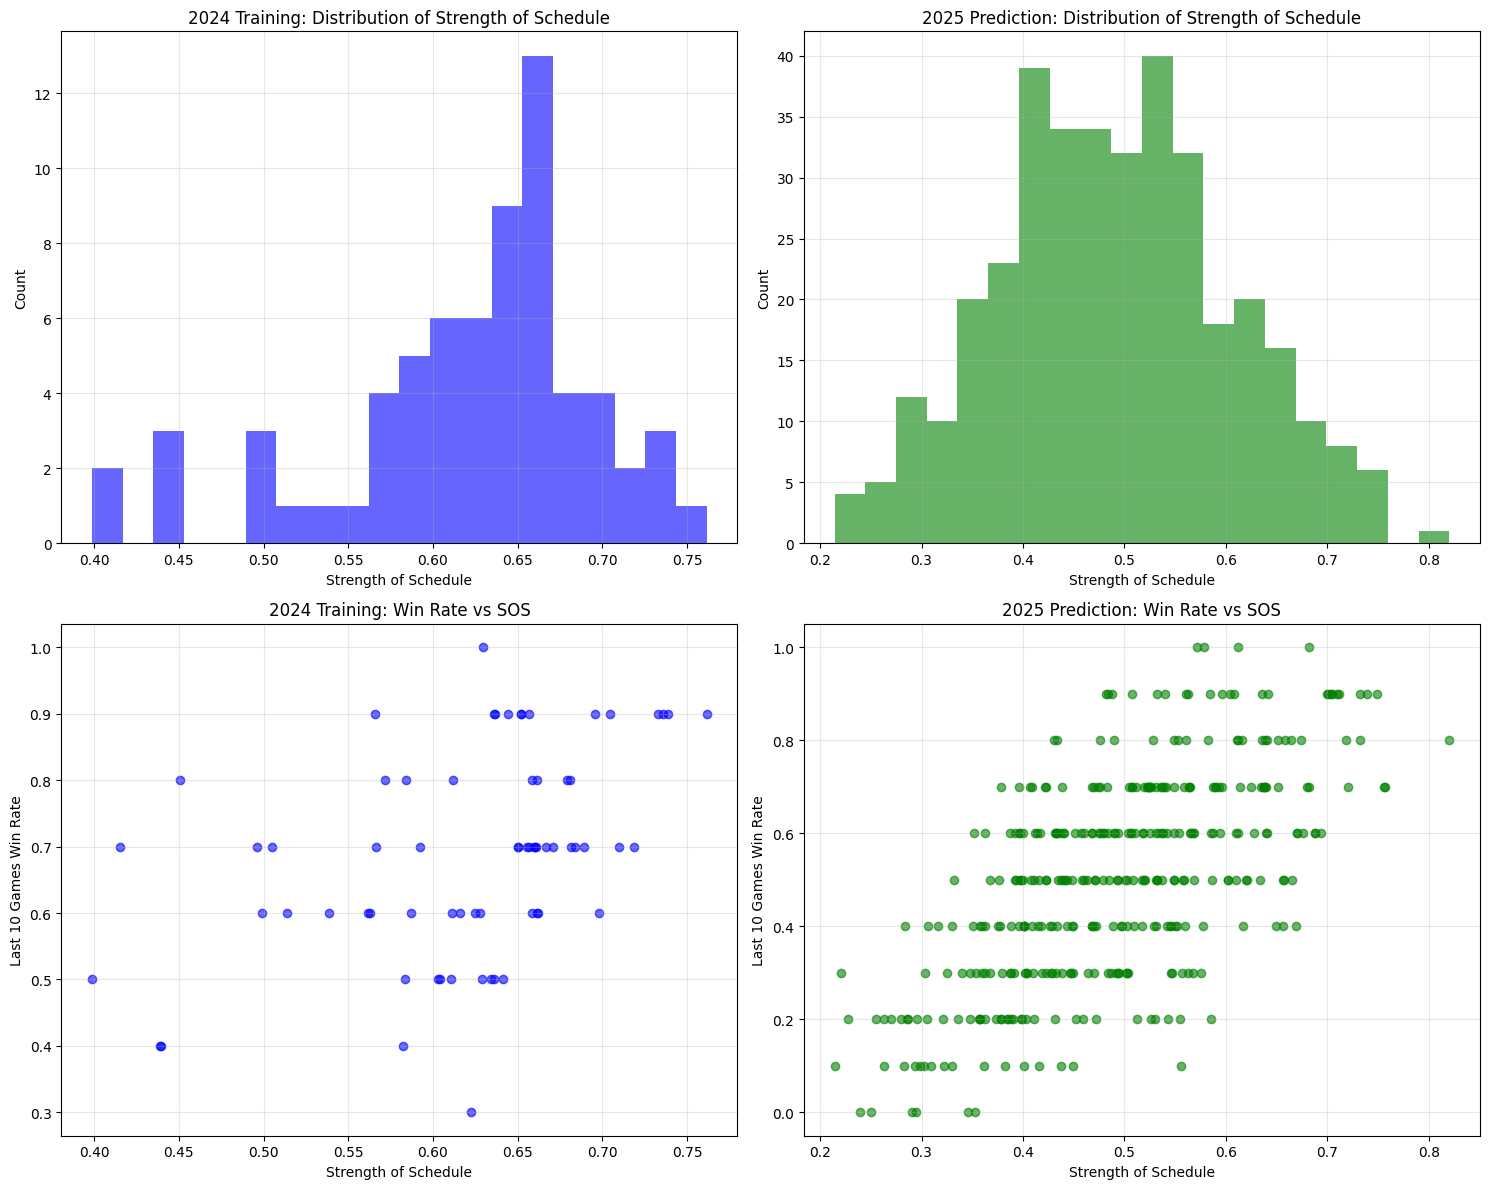


2024 Training SOS Summary:
count    68.000000
mean      0.620236
std       0.078473
min       0.398701
25%       0.583982
50%       0.636390
75%       0.661584
max       0.761657
Name: SOS, dtype: float64

2025 Prediction SOS Summary:
count    364.000000
mean       0.489510
std        0.114491
min        0.214227
25%        0.403218
50%        0.488549
75%        0.563310
max        0.820342
Name: SOS, dtype: float64

Correlation between SOS and Last10WinRate:
2024 Training: 0.41719302033629696
2025 Prediction: 0.6516585365353392


In [81]:
# Enhanced SOS calculation with day number constraint
def calculate_enhanced_sos(games_df, team_id, season, day_num=CURRENT_RANKING_DAY):
    # Filter for season and day number
    games_df = games_df[
        (games_df['Season'] == season) & 
        (games_df['DayNum'] < day_num)
    ]
    
    team_games = games_df[(games_df['WTeamID'] == team_id) | (games_df['LTeamID'] == team_id)]
    if len(team_games) == 0:
        return 0.5  # Default value for teams with no games
        
    # Calculate basic win rate against schedule
    wins = len(team_games[team_games['WTeamID'] == team_id])
    total_games = len(team_games)
    win_rate = wins / total_games
    
    # Calculate opponent strength (average win rate of opponents)
    opponent_strength = 0
    for _, game in team_games.iterrows():
        opponent_id = game['LTeamID'] if game['WTeamID'] == team_id else game['WTeamID']
        opp_games = games_df[
            ((games_df['WTeamID'] == opponent_id) | (games_df['LTeamID'] == opponent_id)) &
            (games_df['DayNum'] < game['DayNum'])  # Only consider games before this one
        ]
        if len(opp_games) > 0:
            opp_wins = len(opp_games[opp_games['WTeamID'] == opponent_id])
            opp_strength = opp_wins / len(opp_games)
            opponent_strength += opp_strength
    
    avg_opponent_strength = opponent_strength / total_games if total_games > 0 else 0.5
    
    # Combine win rate and opponent strength
    sos = (win_rate + avg_opponent_strength) / 2
    return sos

# Calculate SOS for training teams
print("Calculating SOS for 2024 training teams...")
train_team_features['SOS'] = train_team_features['TeamID'].apply(
    lambda x: calculate_enhanced_sos(games, x, TRAIN_SEASON, CURRENT_RANKING_DAY)
)

# Calculate SOS for prediction teams
print("\nCalculating SOS for 2025 prediction teams...")
predict_team_features['SOS'] = predict_team_features.index.map(
    lambda x: calculate_enhanced_sos(games, x, PREDICT_SEASON, CURRENT_RANKING_DAY)
)

# Create visualizations
import matplotlib.pyplot as plt

# Set up the plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot SOS distributions
axes[0,0].hist(train_team_features['SOS'], bins=20, alpha=0.6, color='blue')
axes[0,0].set_title('2024 Training: Distribution of Strength of Schedule')
axes[0,0].set_xlabel('Strength of Schedule')
axes[0,0].set_ylabel('Count')
axes[0,0].grid(True, alpha=0.3)

axes[0,1].hist(predict_team_features['SOS'], bins=20, alpha=0.6, color='green')
axes[0,1].set_title('2025 Prediction: Distribution of Strength of Schedule')
axes[0,1].set_xlabel('Strength of Schedule')
axes[0,1].set_ylabel('Count')
axes[0,1].grid(True, alpha=0.3)

# Plot Win Rate vs SOS
axes[1,0].scatter(train_team_features['SOS'], train_team_features['Last10WinRate'], alpha=0.6, color='blue')
axes[1,0].set_title('2024 Training: Win Rate vs SOS')
axes[1,0].set_xlabel('Strength of Schedule')
axes[1,0].set_ylabel('Last 10 Games Win Rate')
axes[1,0].grid(True, alpha=0.3)

axes[1,1].scatter(predict_team_features['SOS'], predict_team_features['Last10WinRate'], alpha=0.6, color='green')
axes[1,1].set_title('2025 Prediction: Win Rate vs SOS')
axes[1,1].set_xlabel('Strength of Schedule')
axes[1,1].set_ylabel('Last 10 Games Win Rate')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n2024 Training SOS Summary:")
print(train_team_features['SOS'].describe())
print("\n2025 Prediction SOS Summary:")
print(predict_team_features['SOS'].describe())

# Print correlation between SOS and Win Rate
print("\nCorrelation between SOS and Last10WinRate:")
print("2024 Training:", train_team_features['SOS'].corr(train_team_features['Last10WinRate']))
print("2025 Prediction:", predict_team_features['SOS'].corr(predict_team_features['Last10WinRate']))

In [92]:
# Split into train and test using CURRENT_RANKING_DAY and only 2024 season
print(f"Using 2024 games up to day {CURRENT_RANKING_DAY} for training")
train_games = games[
    (games["Season"] == TRAIN_SEASON) & 
    (games["DayNum"] <= CURRENT_RANKING_DAY)
]
print(f"Number of training games: {len(train_games)}")

# Print column names for debugging
print("\nTraining columns:", train_team_features.columns.tolist())
print("Prediction columns:", predict_team_features.columns.tolist())

# Ensure all ranking systems are present in both datasets
all_systems = ['MAS', 'ESR', 'POM']  # Use only consistently available systems
for system in all_systems:
    if system not in predict_team_features.columns:
        predict_team_features[system] = 0
    if system not in train_team_features.columns:
        train_team_features[system] = 0

# We only need training team features for model training
required_columns = ['TeamID', 'Season', 'SeedValue', 'RegionName', 'SOS', 'HomeWinRate', 'AwayWinRate', 'NeutralWinRate'] + all_systems
print("\nRequired columns:", required_columns)

# Add any missing columns with default values to training features
for col in required_columns:
    if col not in train_team_features.columns:
        print(f"Adding missing column to training data: {col}")
        train_team_features[col] = 0

print("\nTraining team features shape:", train_team_features.shape)
print("Sample of training team features:")
print(train_team_features.head())



Using 2024 games up to day 121 for training
Number of training games: 5202

Training columns: ['Season', 'Seed', 'TeamID', 'SeedValue', 'Region', 'RegionName', 'TPR', 'MAS', 'ESR', 'POM', 'USA', 'AP', 'Last10WinRate', 'HomeWinRate', 'AwayWinRate', 'NeutralWinRate', 'SOS']
Prediction columns: ['MAS', 'ESR', 'POM', 'USA', 'AP', 'Last10WinRate', 'HomeWinRate', 'AwayWinRate', 'NeutralWinRate', 'SOS']

Required columns: ['TeamID', 'Season', 'SeedValue', 'RegionName', 'SOS', 'HomeWinRate', 'AwayWinRate', 'NeutralWinRate', 'MAS', 'ESR', 'POM']

Training team features shape: (68, 17)
Sample of training team features:
   Season Seed  TeamID  SeedValue Region RegionName       TPR       MAS  \
0    2024  W01    1163        0.0      W       East  1.000000  0.994460   
1    2024  W02    1235        0.0      W       East  0.972299  0.983380   
2    2024  W03    1228        0.0      W       East  0.975069  0.963989   
3    2024  W04    1120        0.0      W       East  0.983380  0.961219   
4    202

In [94]:
from sklearn.ensemble import GradientBoostingClassifier

# Print initial data shapes
print("Initial data shapes:")
print(f"train_games shape: {train_games.shape}")
print(f"train_team_features shape: {train_team_features.shape}")
print("\nSample of train_team_features:")
print(train_team_features[['TeamID', 'SeedValue', 'HomeWinRate', 'AwayWinRate', 'NeutralWinRate']].head())

# Modified feature creation with better error handling
train_data = []
processed_games = 0
skipped_games = 0
error_types = {}

for _, row in train_games.iterrows():
    team1, team2 = row["WTeamID"], row["LTeamID"]
    
    # Check if both teams exist in training features
    team1_data = train_team_features[train_team_features["TeamID"] == team1]
    team2_data = train_team_features[train_team_features["TeamID"] == team2]
    
    if team1_data.empty or team2_data.empty:
        skipped_games += 1
        error_msg = f"Missing team data: Team1={team1} ({'present' if not team1_data.empty else 'missing'}), Team2={team2} ({'present' if not team2_data.empty else 'missing'})"
        error_types[error_msg] = error_types.get(error_msg, 0) + 1
        continue
        
    team1_features = team1_data.iloc[0]
    team2_features = team2_data.iloc[0]
    
    try:
        # Print debug info for first few games
        if processed_games < 3:
            print(f"\nProcessing game {processed_games + 1}:")
            print(f"Team1 ({team1}) features:")
            print(team1_features[['SeedValue', 'HomeWinRate', 'AwayWinRate', 'NeutralWinRate', 'SOS']])
            print(f"\nTeam2 ({team2}) features:")
            print(team2_features[['SeedValue', 'HomeWinRate', 'AwayWinRate', 'NeutralWinRate', 'SOS']])
        
        features = {
            "Seed_Diff": float(team1_features["SeedValue"] - team2_features["SeedValue"]),
            # Raw normalized rankings for each team
            "Team1_MAS": float(team1_features["MAS"]),
            "Team2_MAS": float(team2_features["MAS"]),
            "Team1_ESR": float(team1_features["ESR"]),
            "Team2_ESR": float(team2_features["ESR"]),
            "Team1_POM": float(team1_features["POM"]),
            "Team2_POM": float(team2_features["POM"]),
            # Differences in rankings
            "Ranking_Diff_MAS": float(team1_features["MAS"] - team2_features["MAS"]),
            "Ranking_Diff_ESR": float(team1_features["ESR"] - team2_features["ESR"]),
            "Ranking_Diff_POM": float(team1_features["POM"] - team2_features["POM"]),
            # Products of rankings
            "Ranking_Prod_MAS": float(team1_features["MAS"] * team2_features["MAS"]),
            "Ranking_Prod_ESR": float(team1_features["ESR"] * team2_features["ESR"]),
            "Ranking_Prod_POM": float(team1_features["POM"] * team2_features["POM"]),
            # Win rates
            "Last10WinRate_Team1": float(team1_features["Last10WinRate"]),
            "Last10WinRate_Team2": float(team2_features["Last10WinRate"]),
            "WinRate_Diff": float(team1_features["Last10WinRate"] - team2_features["Last10WinRate"]),
            # SOS and Location features
            'SOS_Team1': float(team1_features["SOS"]),
            'SOS_Team2': float(team2_features["SOS"]),
            'SOS_Diff': float(team1_features["SOS"] - team2_features["SOS"]),
            'HomeWinRate_Team1': float(team1_features["HomeWinRate"]),
            'AwayWinRate_Team2': float(team2_features["AwayWinRate"]),
            'NeutralWinRate_Team1': float(team1_features["NeutralWinRate"]),
            'NeutralWinRate_Team2': float(team2_features["NeutralWinRate"]),
            'HomeAway_Advantage': float(team1_features["HomeWinRate"] - team2_features["AwayWinRate"]),
            "Outcome": 1
        }
        
        # Add squared differences
        features.update({
            "Ranking_Diff_MAS_Squared": features["Ranking_Diff_MAS"] ** 2,
            "Ranking_Diff_ESR_Squared": features["Ranking_Diff_ESR"] ** 2,
            "Ranking_Diff_POM_Squared": features["Ranking_Diff_POM"] ** 2,
        })
        
        # Create reverse matchup
        reverse_features = features.copy()
        reverse_features.update({
            "Team1_MAS": features["Team2_MAS"],
            "Team2_MAS": features["Team1_MAS"],
            "Team1_ESR": features["Team2_ESR"],
            "Team2_ESR": features["Team1_ESR"],
            "Team1_POM": features["Team2_POM"],
            "Team2_POM": features["Team1_POM"],
            "Last10WinRate_Team1": features["Last10WinRate_Team2"],
            "Last10WinRate_Team2": features["Last10WinRate_Team1"],
            "SOS_Team1": features["SOS_Team2"],
            "SOS_Team2": features["SOS_Team1"],
            "HomeWinRate_Team1": features["HomeWinRate_Team1"],  # These should be swapped if home/away is known
            "AwayWinRate_Team2": features["AwayWinRate_Team2"],
            "NeutralWinRate_Team1": features["NeutralWinRate_Team2"],
            "NeutralWinRate_Team2": features["NeutralWinRate_Team1"],
        })
        
        # Negate differences
        for key in features.keys():
            if any(key.startswith(prefix) for prefix in ["Ranking_Diff_", "Seed_Diff", "WinRate_Diff", "SOS_Diff", "HomeAway_Advantage"]):
                if not key.endswith("_Squared"):
                    reverse_features[key] = -features[key]
        
        reverse_features["Outcome"] = 0
        
        train_data.append(features)
        train_data.append(reverse_features)
        processed_games += 1
        
    except Exception as e:
        error_msg = str(e)
        error_types[error_msg] = error_types.get(error_msg, 0) + 1
        if processed_games < 5:  # Only print first 5 errors in detail
            print(f"\nError processing game: Team1={team1}, Team2={team2}")
            print(f"Error: {error_msg}")
        continue

print(f"\nProcessed {processed_games} games successfully")
print(f"Skipped {skipped_games} games due to missing team data")

print("\nError type summary:")
for error_msg, count in error_types.items():
    print(f"{error_msg}: {count} occurrences")

if len(train_data) == 0:
    print("\nERROR: No training data was created!")
    print("Please check the above debug information to identify the issue.")
else:
    # Convert to DataFrame
    df_train = pd.DataFrame(train_data)
    
    # Print feature statistics
    print("\nFeature Statistics:")
    print(df_train.describe().round(3))
    
    # Print value counts for categorical features
    print("\nOutcome distribution:")
    print(df_train['Outcome'].value_counts())
    
    # Train model
    X_train = df_train.drop('Outcome', axis=1)
    y_train = df_train['Outcome']
    
    model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
    model.fit(X_train, y_train)
    
    # Print feature importance
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))

Initial data shapes:
train_games shape: (5202, 8)
train_team_features shape: (68, 17)

Sample of train_team_features:
   TeamID  SeedValue  HomeWinRate  AwayWinRate  NeutralWinRate
0    1163        0.0          0.5          0.5             0.5
1    1235        0.0          0.5          0.5             0.5
2    1228        0.0          0.5          0.5             0.5
3    1120        0.0          0.5          0.5             0.5
4    1361        0.0          0.5          0.5             0.5

Processing game 1:
Team1 (1103) features:
SeedValue              0.0
HomeWinRate            0.5
AwayWinRate            0.5
NeutralWinRate         0.5
SOS               0.562619
Name: 47, dtype: object

Team2 (1355) features:
SeedValue              0.0
HomeWinRate            0.5
AwayWinRate            0.5
NeutralWinRate         0.5
SOS               0.504788
Name: 14, dtype: object

Processing game 2:
Team1 (1104) features:
SeedValue              0.0
HomeWinRate            0.5
AwayWinRate           

In [95]:
# Display training features
print("Training Features Sample (first 25 rows):")
print("\nShape:", X_train.shape)
print("\nColumns:", X_train.columns.tolist())
print("\nData:")
print(X_train.head(25))

# Display some basic statistics
print("\nFeature Statistics:")
print(X_train.describe().round(3))

Training Features Sample (first 25 rows):

Shape: (528, 27)

Columns: ['Seed_Diff', 'Team1_MAS', 'Team2_MAS', 'Team1_ESR', 'Team2_ESR', 'Team1_POM', 'Team2_POM', 'Ranking_Diff_MAS', 'Ranking_Diff_ESR', 'Ranking_Diff_POM', 'Ranking_Prod_MAS', 'Ranking_Prod_ESR', 'Ranking_Prod_POM', 'Last10WinRate_Team1', 'Last10WinRate_Team2', 'WinRate_Diff', 'SOS_Team1', 'SOS_Team2', 'SOS_Diff', 'HomeWinRate_Team1', 'AwayWinRate_Team2', 'NeutralWinRate_Team1', 'NeutralWinRate_Team2', 'HomeAway_Advantage', 'Ranking_Diff_MAS_Squared', 'Ranking_Diff_ESR_Squared', 'Ranking_Diff_POM_Squared']

Data:
    Seed_Diff  Team1_MAS  Team2_MAS  Team1_ESR  Team2_ESR  Team1_POM  \
0         0.0   0.714681   0.578947   0.734072   0.520776   0.722992   
1        -0.0   0.578947   0.714681   0.520776   0.734072   0.590028   
2         0.0   0.975069   0.598338   0.969529   0.673130   0.980609   
3        -0.0   0.598338   0.975069   0.673130   0.969529   0.662050   
4         0.0   0.833795   0.916898   0.894737   0.8725

In [96]:
# Train the model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Print model performance
y_pred = model.predict(X_train)
print("Training Accuracy:", accuracy_score(y_train, y_pred))

# Look at feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': abs(model.coef_[0])
})
print("\nFeature Importance:")
print(feature_importance.sort_values('Importance', ascending=False))

Training Accuracy: 0.6704545454545454

Feature Importance:
                     Feature    Importance
8           Ranking_Diff_ESR  1.452233e+00
18                  SOS_Diff  1.354970e+00
7           Ranking_Diff_MAS  1.209474e+00
9           Ranking_Diff_POM  1.145290e+00
3                  Team1_ESR  7.261254e-01
4                  Team2_ESR  7.261076e-01
16                 SOS_Team1  6.774917e-01
17                 SOS_Team2  6.774785e-01
1                  Team1_MAS  6.047459e-01
2                  Team2_MAS  6.047284e-01
5                  Team1_POM  5.726536e-01
6                  Team2_POM  5.726360e-01
15              WinRate_Diff  5.165926e-01
13       Last10WinRate_Team1  2.583035e-01
14       Last10WinRate_Team2  2.582891e-01
11          Ranking_Prod_ESR  7.521383e-06
10          Ranking_Prod_MAS  7.281155e-06
12          Ranking_Prod_POM  7.272420e-06
22      NeutralWinRate_Team2  5.288669e-06
19         HomeWinRate_Team1  5.288669e-06
20         AwayWinRate_Team2  5.288669

In [101]:
# Create a more readable matchup display
print("Sample of Training Matchups with Features:")
display_columns = [
    'Outcome',
    'Seed_Diff', 'SOS_Diff',
    'Last10WinRate_Team1', 'Last10WinRate_Team2',
    'Team1_MAS', 'Team2_MAS',
    'Team1_ESR', 'Team2_ESR',
    'Team1_POM', 'Team2_POM',
    'HomeWinRate_Team1', 'AwayWinRate_Team2',
    'NeutralWinRate_Team1', 'NeutralWinRate_Team2'
]

# Display matchups and features
if 'df_train' in locals():
    # First verify what columns we actually have
    print("\nAvailable columns in df_train:")
    print(df_train.columns.tolist())
    
    # Display the data
    matchups_display = df_train[display_columns].head(25)
    
    # Round floating point numbers for better display
    float_cols = matchups_display.select_dtypes(include=['float64']).columns
    matchups_display[float_cols] = matchups_display[float_cols].round(3)
    
    print("\nShape of training data:", df_train.shape)
    print("\nFeature summary:")
    print(matchups_display)
    
    # Print some basic statistics
    print("\nAverage feature values for wins vs losses:")
    print(df_train.groupby('Outcome')[display_columns].mean().round(3))
else:
    print("No training data available yet. Please run the feature creation cell first.")

Sample of Training Matchups with Features:

Available columns in df_train:
['Seed_Diff', 'Team1_MAS', 'Team2_MAS', 'Team1_ESR', 'Team2_ESR', 'Team1_POM', 'Team2_POM', 'Ranking_Diff_MAS', 'Ranking_Diff_ESR', 'Ranking_Diff_POM', 'Ranking_Prod_MAS', 'Ranking_Prod_ESR', 'Ranking_Prod_POM', 'Last10WinRate_Team1', 'Last10WinRate_Team2', 'WinRate_Diff', 'SOS_Team1', 'SOS_Team2', 'SOS_Diff', 'HomeWinRate_Team1', 'AwayWinRate_Team2', 'NeutralWinRate_Team1', 'NeutralWinRate_Team2', 'HomeAway_Advantage', 'Outcome', 'Ranking_Diff_MAS_Squared', 'Ranking_Diff_ESR_Squared', 'Ranking_Diff_POM_Squared']

Shape of training data: (528, 28)

Feature summary:
    Outcome  Seed_Diff  SOS_Diff  Last10WinRate_Team1  Last10WinRate_Team2  \
0         1        0.0     0.058                  0.6                  0.7   
1         0       -0.0    -0.058                  0.7                  0.6   
2         1        0.0     0.093                  0.6                  0.7   
3         0       -0.0    -0.093         

In [106]:
# Add necessary imports
import numpy as np
from sklearn.metrics import accuracy_score, log_loss

# Create prediction matchups for 2025 teams
print("Creating 2025 prediction matchups...")

# Get all teams from 2025 prediction data
prediction_teams = predict_team_features[predict_team_features['Season'] == PREDICT_SEASON]
print(f"\nNumber of 2025 teams: {len(prediction_teams)}")

# Print sample of teams for verification
print("\nSample of 2025 teams:")
print(prediction_teams[['MAS', 'ESR', 'POM', 'SOS', 'Last10WinRate']].head())

# Create all possible matchups between teams
prediction_matchups = []
for idx1, team1 in prediction_teams.iterrows():
    for idx2, team2 in prediction_teams.iterrows():
        if idx1 < idx2:  # Avoid duplicate matchups
            prediction_matchups.append({
                'Team1': idx1,  # Using index as TeamID
                'Team2': idx2,
                'Season': PREDICT_SEASON
            })

prediction_matchups = pd.DataFrame(prediction_matchups)

# Print prediction data info
print("\nPrediction Data Summary:")
print(f"Total possible matchups: {len(prediction_matchups)}")
print("\nSample of prediction matchups:")
print(prediction_matchups.head())

# Prepare prediction features
prediction_data = []
processed_indices = []  # Track which matchups we successfully process

print(f"\nCreating predictions using games up to day {CURRENT_RANKING_DAY}")

for idx, row in prediction_matchups.iterrows():
    team1, team2 = row["Team1"], row["Team2"]
    season = row["Season"]
    
    # Get team features for the correct season
    team1_data = team_features[(team_features["TeamID"] == team1) & (team_features["Season"] == season)]
    team2_data = team_features[(team_features["TeamID"] == team2) & (team_features["Season"] == season)]
    
    if team1_data.empty or team2_data.empty:
        if idx < 5:  # Only print first 5 skipped matchups
            print(f"Skipping matchup {idx}: Team1={team1}, Team2={team2}, Season={season} - missing team data")
        continue
        
    team1_features = team1_data.iloc[0]
    team2_features = team2_data.iloc[0]
    
    try:
        features = {
            "Seed_Diff": 0,  # No seeds yet for 2025
            # Raw normalized rankings for each team
            "Team1_MAS": team1_features["MAS"],
            "Team2_MAS": team2_features["MAS"],
            "Team1_ESR": team1_features["ESR"],
            "Team2_ESR": team2_features["ESR"],
            "Team1_POM": team1_features["POM"],
            "Team2_POM": team2_features["POM"],
            # Differences in rankings
            "Ranking_Diff_MAS": team1_features["MAS"] - team2_features["MAS"],
            "Ranking_Diff_ESR": team1_features["ESR"] - team2_features["ESR"],
            "Ranking_Diff_POM": team1_features["POM"] - team2_features["POM"],
            # Products of rankings
            "Ranking_Prod_MAS": team1_features["MAS"] * team2_features["MAS"],
            "Ranking_Prod_ESR": team1_features["ESR"] * team2_features["ESR"],
            "Ranking_Prod_POM": team1_features["POM"] * team2_features["POM"],
            # Win rates using updated function
            "Last10WinRate_Team1": get_last_n_games_win_rate(team1, season),
            "Last10WinRate_Team2": get_last_n_games_win_rate(team2, season),
            "WinRate_Diff": (get_last_n_games_win_rate(team1, season) - 
                           get_last_n_games_win_rate(team2, season)),
            # SOS and Location features
            'SOS_Team1': team1_features["SOS"],
            'SOS_Team2': team2_features["SOS"],
            'SOS_Diff': team1_features["SOS"] - team2_features["SOS"],
            'HomeWinRate_Team1': team1_features["HomeWinRate"],
            'AwayWinRate_Team2': team2_features["AwayWinRate"],
            'NeutralWinRate_Team1': team1_features["NeutralWinRate"],
            'NeutralWinRate_Team2': team2_features["NeutralWinRate"],
            'HomeAway_Advantage': team1_features["HomeWinRate"] - team2_features["AwayWinRate"]
        }
        
        # Add squared differences
        features.update({
            "Ranking_Diff_MAS_Squared": features["Ranking_Diff_MAS"] ** 2,
            "Ranking_Diff_ESR_Squared": features["Ranking_Diff_ESR"] ** 2,
            "Ranking_Diff_POM_Squared": features["Ranking_Diff_POM"] ** 2,
        })
        
        prediction_data.append(features)
        processed_indices.append(idx)
        
    except Exception as e:
        if idx < 5:  # Only print first 5 errors
            print(f"Error processing matchup {idx}: Team1={team1}, Team2={team2}")
            print(f"Error: {str(e)}")
        continue

if len(prediction_data) == 0:
    print("\nERROR: No prediction data was created!")
    print("Please check the above debug information to identify the issue.")
else:
    # Convert to DataFrame and ensure columns match training data
    df_predict = pd.DataFrame(prediction_data)
    
    print("\nPrediction data shape before column alignment:", df_predict.shape)
    print("Prediction data columns:", df_predict.columns.tolist())
    print("Training data columns:", X_train.columns.tolist())
    
    # Add missing columns
    missing_cols = set(X_train.columns) - set(df_predict.columns)
    for col in missing_cols:
        print(f"Adding missing column to prediction data: {col}")
        df_predict[col] = 0

    # Remove extra columns
    extra_cols = set(df_predict.columns) - set(X_train.columns)
    if extra_cols:
        print(f"\nWarning: Extra columns in prediction data that weren't in training: {extra_cols}")
        df_predict = df_predict[X_train.columns]

    # Make predictions
    predictions = model.predict_proba(df_predict)
    predicted_wins = predictions[:, 1]

    # Add predictions to results using only processed matchups
    processed_matchups = prediction_matchups.iloc[processed_indices].reset_index(drop=True)
    results = pd.DataFrame({
        'Team1': processed_matchups['Team1'],
        'Team2': processed_matchups['Team2'],
        'Predicted_Win_Probability': predicted_wins
    })

    # Print prediction summary
    print("\nPrediction Summary:")
    print(f"Successfully processed {len(processed_indices)} out of {len(prediction_matchups)} possible matchups")

    # Print sample predictions
    print("\nSample Predictions (sorted by win probability):")
    print(results.sort_values('Predicted_Win_Probability', ascending=False).head(10))

    # Print prediction distribution statistics
    print("\nPrediction Distribution:")
    print(results['Predicted_Win_Probability'].describe().round(3))

    # Save prediction results
    results.to_csv('2025_predictions.csv', index=False)
    print("\nPredictions saved to '2025_predictions.csv'")

Creating 2025 prediction matchups...

Number of 2025 teams: 364

Sample of 2025 teams:
SystemName       MAS       ESR       POM       SOS  Last10WinRate
TeamID                                                           
1101        0.432507  0.300275  0.404959  0.406831            0.7
1102        0.179063  0.297521  0.165289  0.302686            0.1
1103        0.724518  0.796143  0.719008  0.596295            0.9
1104        0.991736  0.991736  0.986226  0.756896            0.7
1105        0.027548  0.294766  0.013774  0.284023            0.4

Prediction Data Summary:
Total possible matchups: 66066

Sample of prediction matchups:
   Team1  Team2  Season
0   1101   1102    2025
1   1101   1103    2025
2   1101   1104    2025
3   1101   1105    2025
4   1101   1106    2025

Creating predictions using games up to day 121

Prediction data shape before column alignment: (66066, 27)
Prediction data columns: ['Seed_Diff', 'Team1_MAS', 'Team2_MAS', 'Team1_ESR', 'Team2_ESR', 'Team1_POM', 'Team2

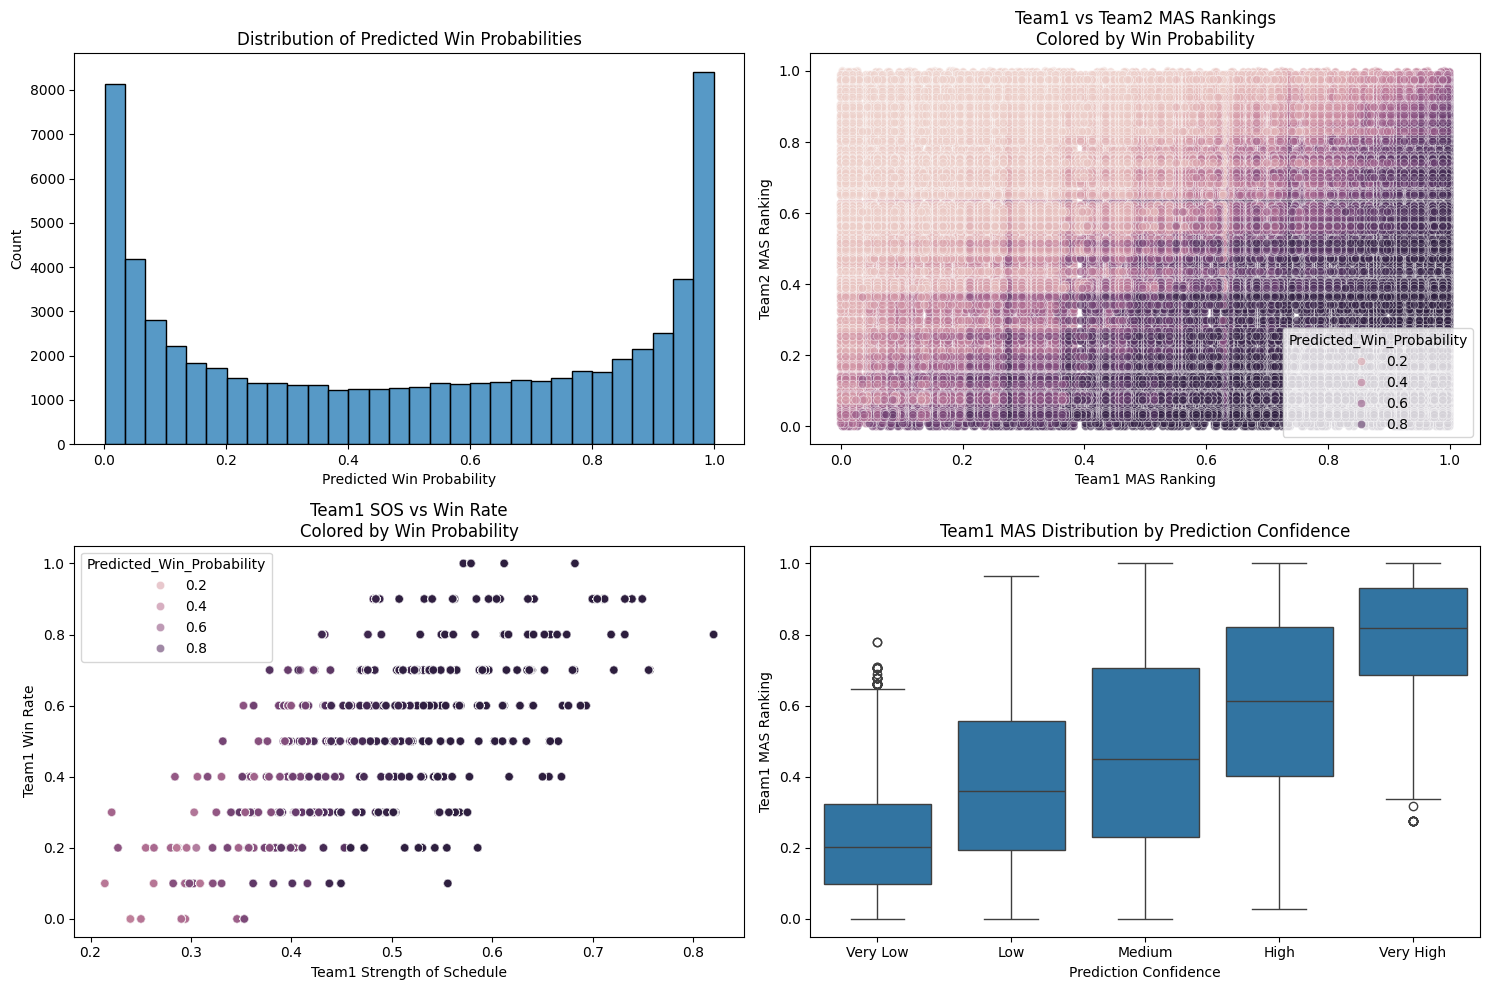


Prediction Analysis by Team Strength:

Stats by Prediction Confidence Level:
                      Team1_MAS        Team2_MAS        Team1_SOS         \
                           mean    std      mean    std      mean    std   
Prediction_Confidence                                                      
Very Low                  0.221  0.152     0.793  0.140     0.386  0.071   
Low                       0.382  0.227     0.621  0.212     0.445  0.087   
Medium                    0.472  0.276     0.485  0.269     0.481  0.104   
High                      0.604  0.248     0.394  0.248     0.532  0.098   
Very High                 0.796  0.155     0.233  0.169     0.607  0.080   

                      Team2_SOS        Team1_WinRate         
                           mean    std          mean    std  
Prediction_Confidence                                        
Very Low                  0.600  0.071         0.375  0.204  
Low                       0.533  0.085         0.462  0.219  
Med

/var/folders/gc/_00hl__j42163556kvkzz4b40000gq/T/ipykernel_58674/2959814057.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  confidence_stats = analysis_df.groupby('Prediction_Confidence').agg({


In [108]:
# Analyze prediction patterns
import seaborn as sns
import matplotlib.pyplot as plt

# Create analysis DataFrame
analysis_df = results.copy()

# Add team ranking information
team_rankings = prediction_teams[['MAS', 'ESR', 'POM', 'SOS', 'Last10WinRate']]
analysis_df['Team1_MAS'] = analysis_df['Team1'].map(team_rankings['MAS'])
analysis_df['Team2_MAS'] = analysis_df['Team2'].map(team_rankings['MAS'])
analysis_df['Team1_SOS'] = analysis_df['Team1'].map(team_rankings['SOS'])
analysis_df['Team2_SOS'] = analysis_df['Team2'].map(team_rankings['SOS'])
analysis_df['Team1_WinRate'] = analysis_df['Team1'].map(team_rankings['Last10WinRate'])
analysis_df['Team2_WinRate'] = analysis_df['Team2'].map(team_rankings['Last10WinRate'])

# Create visualizations
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.histplot(data=analysis_df, x='Predicted_Win_Probability', bins=30)
plt.title('Distribution of Predicted Win Probabilities')
plt.xlabel('Predicted Win Probability')
plt.ylabel('Count')

plt.subplot(2, 2, 2)
sns.scatterplot(data=analysis_df, 
                x='Team1_MAS', 
                y='Team2_MAS', 
                hue='Predicted_Win_Probability',
                alpha=0.6)
plt.title('Team1 vs Team2 MAS Rankings\nColored by Win Probability')
plt.xlabel('Team1 MAS Ranking')
plt.ylabel('Team2 MAS Ranking')

plt.subplot(2, 2, 3)
sns.scatterplot(data=analysis_df,
                x='Team1_SOS',
                y='Team1_WinRate',
                hue='Predicted_Win_Probability',
                alpha=0.6)
plt.title('Team1 SOS vs Win Rate\nColored by Win Probability')
plt.xlabel('Team1 Strength of Schedule')
plt.ylabel('Team1 Win Rate')

plt.subplot(2, 2, 4)
sns.boxplot(data=analysis_df,
            x=pd.qcut(analysis_df['Predicted_Win_Probability'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']),
            y='Team1_MAS')
plt.title('Team1 MAS Distribution by Prediction Confidence')
plt.xlabel('Prediction Confidence')
plt.ylabel('Team1 MAS Ranking')

plt.tight_layout()
plt.show()

# Print statistical analysis
print("\nPrediction Analysis by Team Strength:")
analysis_df['Prediction_Confidence'] = pd.qcut(analysis_df['Predicted_Win_Probability'], 
                                             q=5, 
                                             labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

confidence_stats = analysis_df.groupby('Prediction_Confidence').agg({
    'Team1_MAS': ['mean', 'std'],
    'Team2_MAS': ['mean', 'std'],
    'Team1_SOS': ['mean', 'std'],
    'Team2_SOS': ['mean', 'std'],
    'Team1_WinRate': ['mean', 'std']
}).round(3)

print("\nStats by Prediction Confidence Level:")
print(confidence_stats)

# Find most lopsided predicted matchups
print("\nMost Lopsided Predicted Matchups:")
lopsided_matchups = analysis_df.nlargest(10, 'Predicted_Win_Probability')[
    ['Team1', 'Team2', 'Predicted_Win_Probability', 'Team1_MAS', 'Team2_MAS']
].round(3)
print(lopsided_matchups)

# Find closest predicted matchups
print("\nClosest Predicted Matchups:")
close_matchups = analysis_df.iloc[(analysis_df['Predicted_Win_Probability'] - 0.5).abs().argsort()[:10]][
    ['Team1', 'Team2', 'Predicted_Win_Probability', 'Team1_MAS', 'Team2_MAS']
].round(3)
print(close_matchups)

# Calculate correlation matrix
print("\nFeature Correlations with Predicted Win Probability:")
correlation_features = ['Predicted_Win_Probability', 'Team1_MAS', 'Team2_MAS', 
                       'Team1_SOS', 'Team2_SOS', 'Team1_WinRate', 'Team2_WinRate']
correlations = analysis_df[correlation_features].corr()['Predicted_Win_Probability'].sort_values(ascending=False)
print(correlations.round(3))

In [1]:
# Add necessary imports
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, precision_score, recall_score
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("Model Performance Evaluation")
print("-" * 50)

# Create and train the main model
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Perform k-fold cross validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
cv_scores = {
    'accuracy': [],
    'log_loss': [],
    'roc_auc': [],
    'precision': [],
    'recall': []
}

print(f"\nPerforming {k_folds}-fold cross-validation...")
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
    # Split data
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Train model
    fold_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    fold_model.fit(X_fold_train, y_fold_train)
    
    # Make predictions
    y_pred_proba = fold_model.predict_proba(X_fold_val)[:, 1]
    y_pred = y_pred_proba > 0.5
    
    # Calculate metrics
    cv_scores['accuracy'].append(accuracy_score(y_fold_val, y_pred))
    cv_scores['log_loss'].append(log_loss(y_fold_val, y_pred_proba))
    cv_scores['roc_auc'].append(roc_auc_score(y_fold_val, y_pred_proba))
    cv_scores['precision'].append(precision_score(y_fold_val, y_pred))
    cv_scores['recall'].append(recall_score(y_fold_val, y_pred))
    
    print(f"\nFold {fold} Results:")
    print(f"Accuracy: {cv_scores['accuracy'][-1]:.3f}")
    print(f"Log Loss: {cv_scores['log_loss'][-1]:.3f}")
    print(f"ROC AUC: {cv_scores['roc_auc'][-1]:.3f}")
    print(f"Precision: {cv_scores['precision'][-1]:.3f}")
    print(f"Recall: {cv_scores['recall'][-1]:.3f}")

# Print average metrics
print("\nOverall Model Performance:")
print("-" * 30)
for metric, scores in cv_scores.items():
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    print(f"{metric.replace('_', ' ').title()}:")
    print(f"  Mean: {mean_score:.3f} (+/- {std_score:.3f})")

# Visualize feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
plt.title('Top 15 Most Important Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

# Analyze prediction confidence
print("\nPrediction Confidence Analysis:")
print("-" * 30)
y_pred_proba = model.predict_proba(X_train)[:, 1]
confidence_bins = pd.cut(np.abs(y_pred_proba - 0.5), 
                        bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5],
                        labels=['0-10%', '10-20%', '20-30%', '30-40%', '40-50%'])

confidence_analysis = pd.DataFrame({
    'true_outcome': y_train,
    'predicted_prob': y_pred_proba,
    'confidence': confidence_bins
})

confidence_stats = confidence_analysis.groupby('confidence').agg({
    'true_outcome': ['count', 'mean']
}).round(3)

confidence_stats.columns = ['Number of Predictions', 'Accuracy']
print("\nAccuracy by Confidence Level:")
print(confidence_stats)

# Print model parameters
print("\nModel Parameters:")
print("-" * 30)
params = model.get_params()
print("n_estimators:", params['n_estimators'])
print("learning_rate:", params['learning_rate'])
print("max_depth:", params['max_depth'])

# Calculate and print win probability calibration
print("\nWin Probability Calibration:")
print("-" * 30)
prob_bins = pd.cut(y_pred_proba, bins=10)
calibration = pd.DataFrame({
    'predicted_prob': y_pred_proba,
    'actual_outcome': y_train,
    'bin': prob_bins
})

calibration_stats = calibration.groupby('bin').agg({
    'predicted_prob': 'mean',
    'actual_outcome': ['count', 'mean']
}).round(3)

print("\nCalibration by Probability Range:")
print(calibration_stats)

# Additional tournament-specific analysis
print("\nTournament-Specific Analysis:")
print("-" * 30)

# Analyze prediction accuracy by ranking difference
X_train_with_outcome = X_train.copy()
X_train_with_outcome['actual_outcome'] = y_train
X_train_with_outcome['predicted_prob'] = y_pred_proba

# Group by ranking difference ranges
ranking_diff_bins = pd.cut(X_train_with_outcome['Ranking_Diff_MAS'], bins=5)
ranking_analysis = X_train_with_outcome.groupby(ranking_diff_bins).agg({
    'actual_outcome': ['count', 'mean'],
    'predicted_prob': 'mean'
}).round(3)

print("\nPerformance by Ranking Difference:")
print(ranking_analysis)

Model Performance Evaluation
--------------------------------------------------


NameError: name 'X_train' is not defined